## Imports

### Install font and other packages

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
pip install git+https://github.com/quantopian/pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-wjp53q01
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-wjp53q01


### Import Packages

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import homogeneity_score,completeness_score,v_measure_score
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

import matplotlib.ticker as ticker
from itertools import cycle

import pandas_datareader.naver as web_naver

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
idx = pd.IndexSlice

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 
# 유니코드에서  음수 부호설정
plt.rc('axes', unicode_minus=False)
np.random.seed(42)

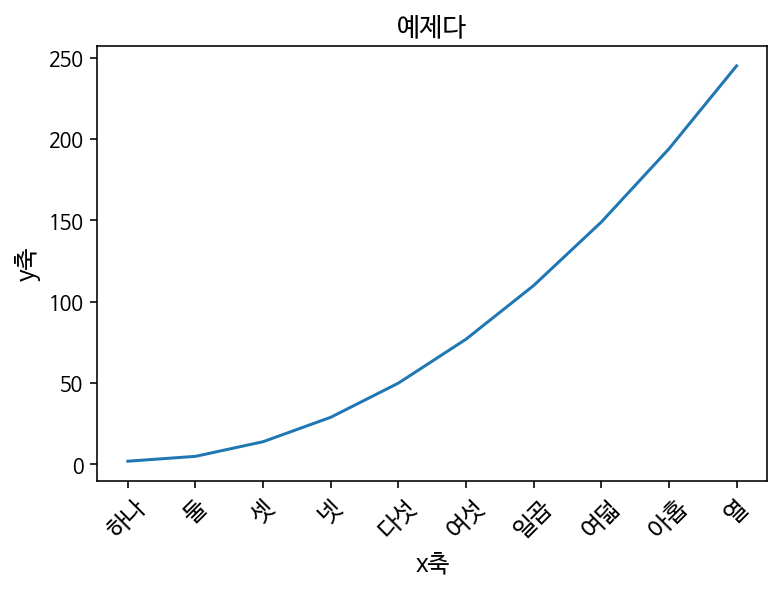

In [ ]:
plt.plot([x for x in range(0, 10)], [(3*y**2)+2 for y in range(0, 10)])
plt.title("예제다", fontsize= 13)
plt.xlabel("x축", fontsize= 12)
plt.xticks(np.arange(0, 10, 1), ['하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '열'], fontsize= 12, rotation= 45)
plt.ylabel("y축", fontsize= 12)
plt.show()

### Import data

In [ ]:
krx100 = pd.read_csv('KRX100.csv', encoding='cp949')
krx100.head()

종목코드       종목명      종가    대비   등락률       상장시가총액
0    5930      삼성전자   60000  2500  4.35  358186953.0
1  373220  LG에너지솔루션  400000   500  0.13   93600000.0
2     660    SK하이닉스   98700  4700  5.00   71853833.0
3  207940  삼성바이오로직스  817000 -8000 -0.97   58149158.0
4    5380       현대차  183500  1000  0.55   39208112.0

In [ ]:
krx300 = pd.read_csv('KRX300.csv', encoding='cp949')
krx300.head()

종목코드       종목명      종가    대비   등락률       상장시가총액
0    5930      삼성전자   60000  2500  4.35  358186953.0
1     660    SK하이닉스   98700  4700  5.00   71853833.0
2  207940  삼성바이오로직스  817000 -8000 -0.97   58149158.0
3    5380       현대차  183500  1000  0.55   39208112.0
4   35420     NAVER  231000 -2500 -1.07   37895339.0

In [ ]:
kospi200 = pd.read_csv('KOSPI200.csv', encoding='cp949')
kospi200.head()

종목코드       종목명      종가    대비   등락률       상장시가총액
0    5930      삼성전자   60000  2500  4.35  358186953.0
1  373220  LG에너지솔루션  400000   500  0.13   93600000.0
2     660    SK하이닉스   98700  4700  5.00   71853833.0
3  207940  삼성바이오로직스  817000 -8000 -0.97   58149158.0
4    5380       현대차  183500  1000  0.55   39208112.0

In [ ]:
kosdaq150 = pd.read_csv('KOSDAQ150.csv', encoding='cp949')
kosdaq150.head()

종목코드       종목명      종가    대비   등락률      상장시가총액
0   91990  셀트리온헬스케어   70500  -800 -1.12  11149919.0
1  247540    에코프로비엠  111500 -5500 -4.70  10904850.0
2   66970      엘앤에프  207500 -5500 -2.58   7455395.0
3   28300       HLB   42800   250  0.59   4574581.0
4  293490    카카오게임즈   49400 -2100 -4.08   3887740.0

In [ ]:
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2022,6,30)
#dataset = pd.concat([kospi200, kosdaq150], axis=0)
#dataset = krx100
dataset = krx300

In [ ]:
def import_price_data(start, end, dataset):
    dictionary = {}
    code_list = dataset['종목코드'].tolist()
    name_list = dataset['종목명'].tolist()
    for i in tqdm(range(len(code_list))):
        code = str(code_list[i]).zfill(6)
        name = name_list[i]
        df = web_naver.NaverDailyReader(symbols=code, start=start, end=end, adjust_price=True).read()
        adj_close = df.Close
        dictionary[name] = adj_close
    data = pd.DataFrame(dictionary)
    data = data.astype('float')
    return data

In [ ]:
df = import_price_data(start, end, dataset)

100%|██████████| 300/300 [06:05<00:00,  1.22s/it]


In [ ]:
# 5% 이상의 결측치가 존재하면 그 종목은 사용하지 않기로 한다.
def dropna_percent(percentage, dataset):
    print('결측치 존재 여부: ', dataset.isnull().values.any())
    missing_fraction = dataset.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fraction[missing_fraction > percentage].index))
    new_df = dataset.drop(labels=drop_list, axis=1)
    print(f"제거한 column의 수는 {len(drop_list)}개 입니다.")
    return new_df

In [ ]:
df = dropna_percent(0.05, df)

결측치 존재 여부:  True
제거한 column의 수는 92개 입니다.


In [ ]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
print(df.shape)
print('결측치 존재 여부: ', df.isnull().values.any())

(2584, 208)
결측치 존재 여부:  False


In [ ]:
train = df[df.index <= '2020-01-20']
test = df[df.index > '2020-01-20']

## Finding pair

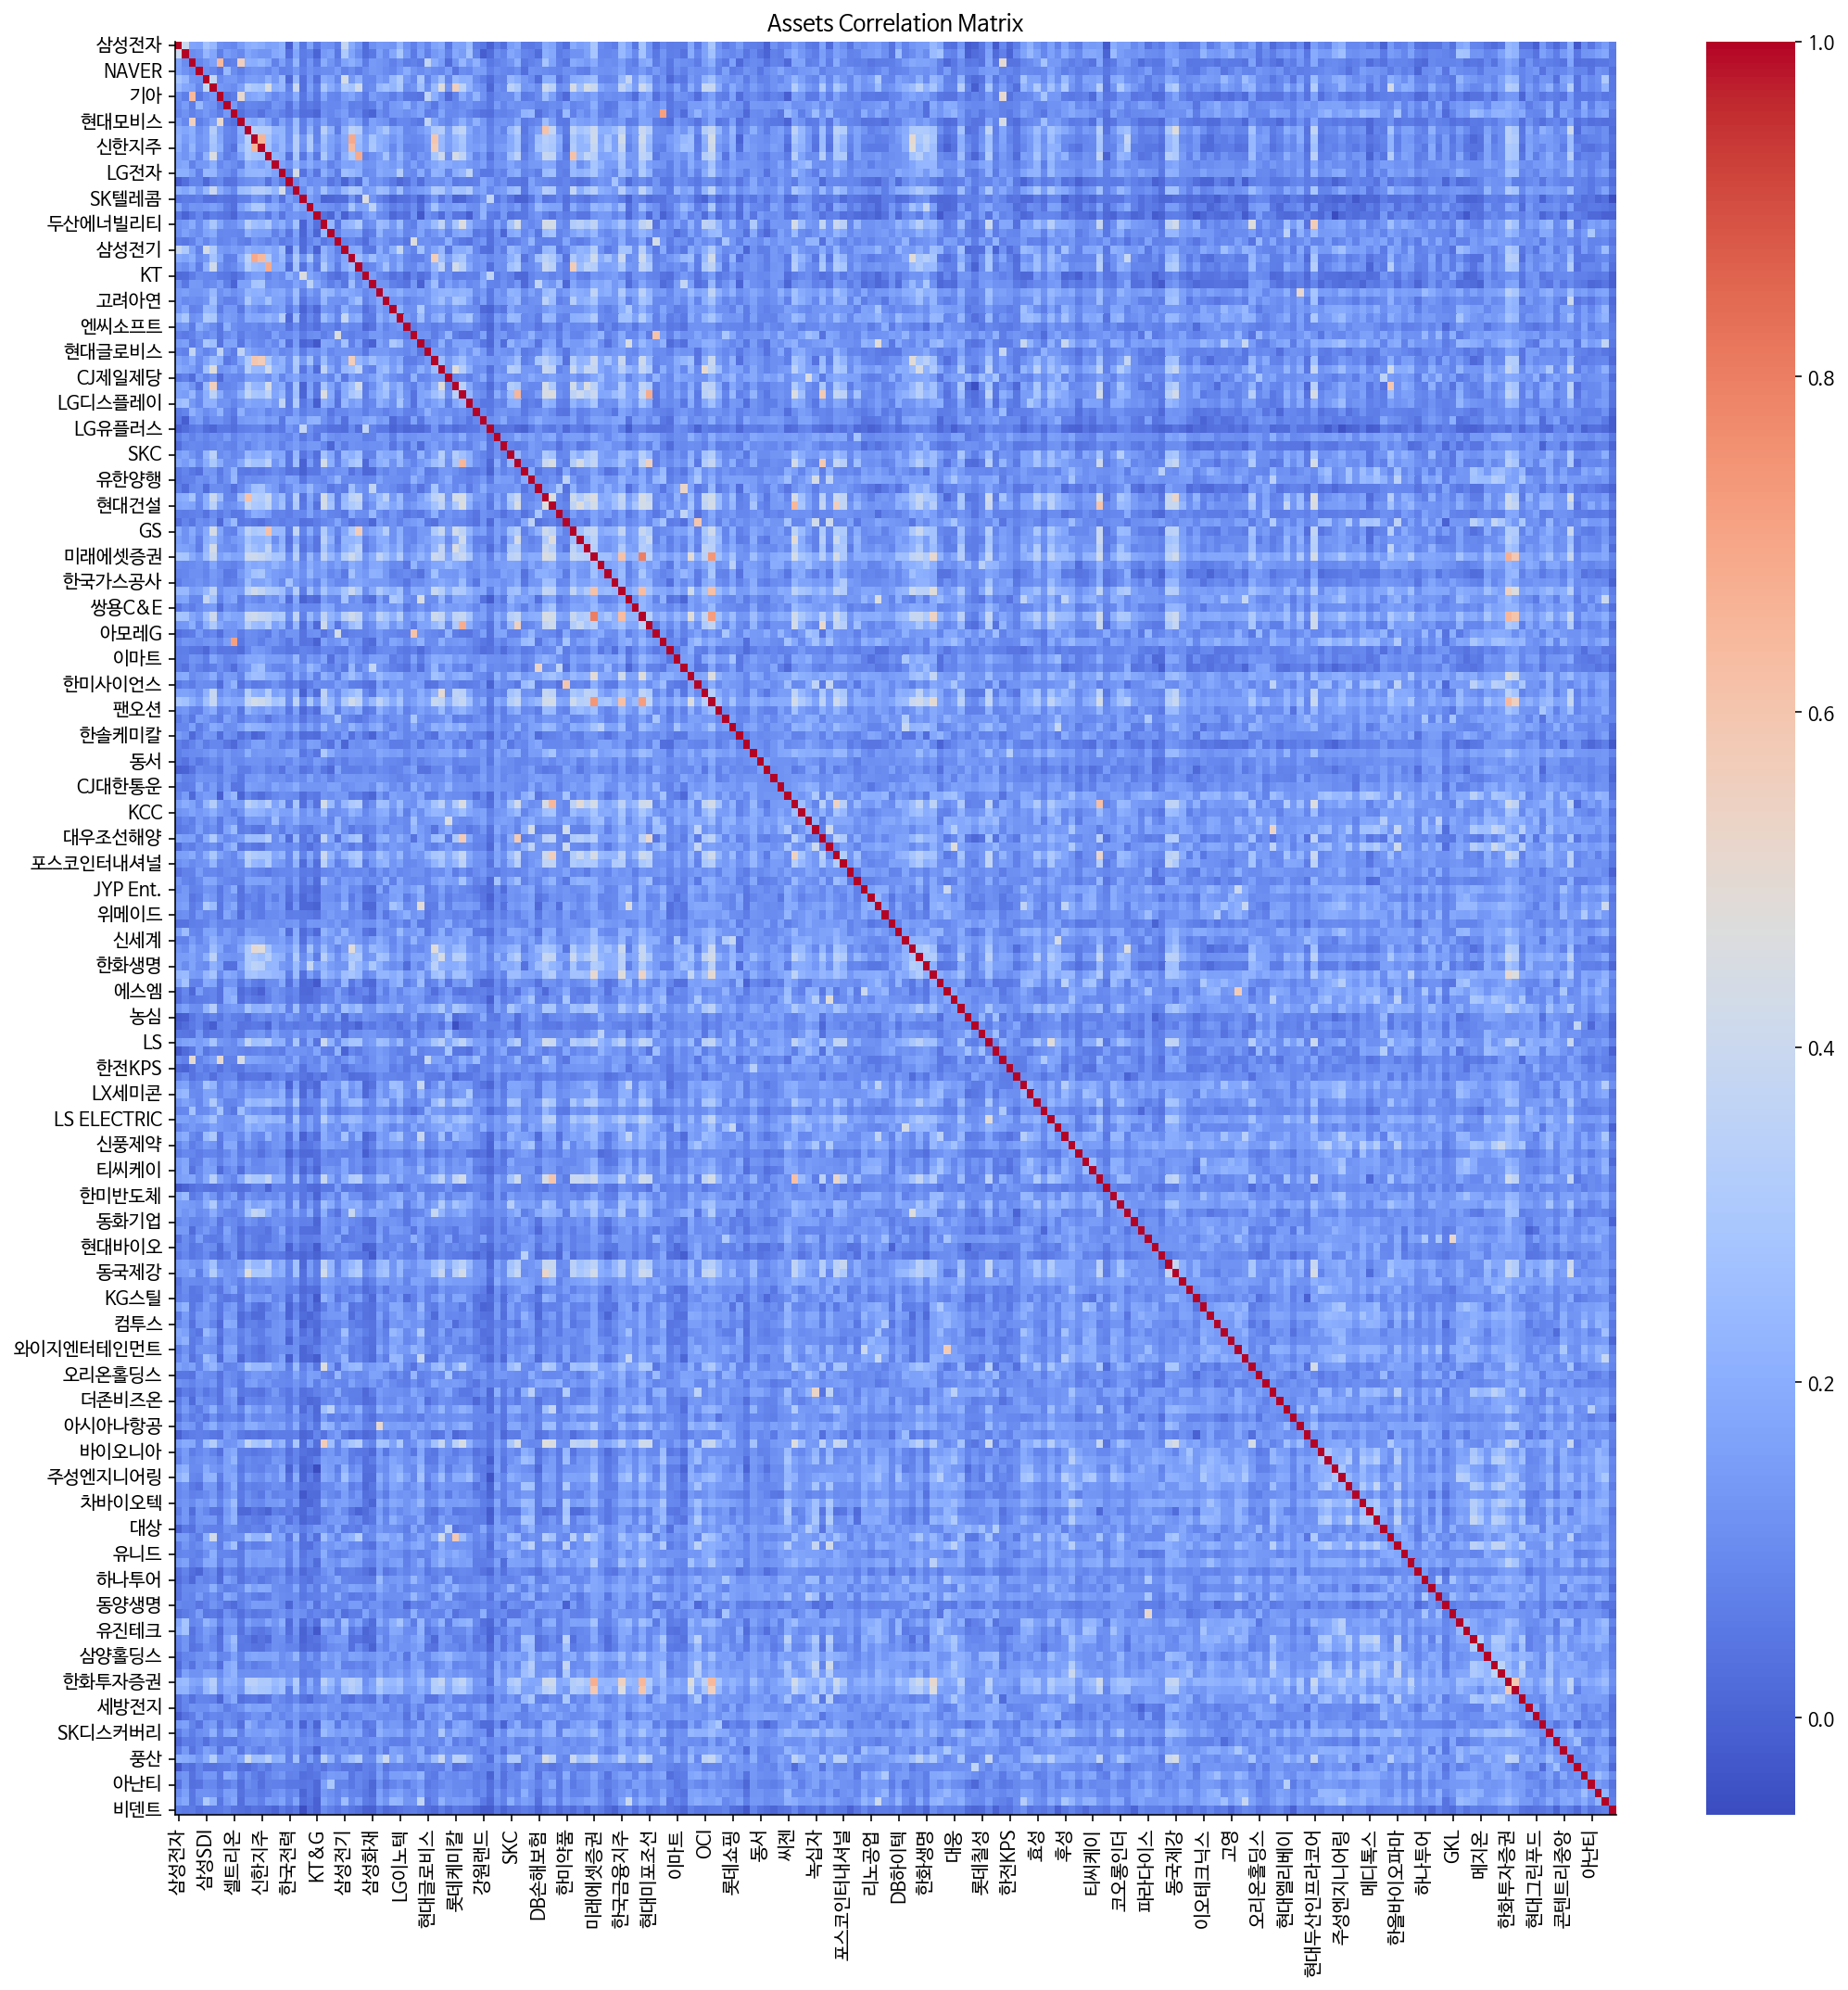

In [ ]:
# Spearman correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(train.pct_change().corr(method ='spearman'),ax=ax, cmap='coolwarm')
ax.set_title('Assets Correlation Matrix')
sns.despine()
plt.tight_layout()

In [ ]:
def find_pairs(data, returns_corr=0.5, price_corr=0.5):
    n = data.shape[1]
    keys = data.keys()
    pairs = []
    returns_matrix = data.pct_change().fillna(0).corr(method='spearman')
    price_matrix = data.corr(method='spearman')
    for i in tqdm(range(n)):
        for j in range(i+1, n):
          if returns_matrix.iloc[i,j] >= returns_corr:
            if price_matrix.iloc[i,j] >= price_corr:
              pairs.append((keys[i], keys[j]))
    return returns_matrix, price_matrix, pairs

In [ ]:
returns_matrix, price_matrix, pairs = find_pairs(train)

100%|██████████| 208/208 [00:00<00:00, 311.39it/s]


In [ ]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 41
In those pairs, there are 48 unique tickers.


In [ ]:
print(len(pairs))
print(pairs)

41
[('현대차', '기아'), ('현대차', '현대모비스'), ('LG화학', '롯데케미칼'), ('기아', '현대모비스'), ('기아', '현대위아'), ('셀트리온', '셀트리온제약'), ('POSCO홀딩스', '현대제철'), ('KB금융', '신한지주'), ('KB금융', '하나금융지주'), ('KB금융', '기업은행'), ('신한지주', '하나금융지주'), ('신한지주', '기업은행'), ('SK이노베이션', 'S-Oil'), ('SK이노베이션', 'GS'), ('두산에너빌리티', '현대두산인프라코어'), ('하나금융지주', '기업은행'), ('S-Oil', 'GS'), ('대한항공', '아시아나항공'), ('아모레퍼시픽', '아모레G'), ('롯데케미칼', '대한유화'), ('한국조선해양', '삼성중공업'), ('한국조선해양', '현대미포조선'), ('한국조선해양', '대우조선해양'), ('삼성중공업', '현대미포조선'), ('삼성중공업', '대우조선해양'), ('DB손해보험', '현대해상'), ('현대제철', '동국제강'), ('현대건설', 'GS건설'), ('현대건설', '대우건설'), ('현대건설', 'DL'), ('한미약품', '한미사이언스'), ('미래에셋증권', '삼성증권'), ('미래에셋증권', '한화투자증권'), ('한국금융지주', 'NH투자증권'), ('NH투자증권', '키움증권'), ('NH투자증권', '대신증권'), ('현대미포조선', '대우조선해양'), ('삼성증권', '한화투자증권'), ('GS건설', 'DL'), ('녹십자', '녹십자홀딩스'), ('파라다이스', 'GKL')]


## Perform EDA for Selected pair

### Choose one pair

In [ ]:
asset1 = 'GS'
asset2 = 'S-Oil'

In [ ]:
pair1 = pd.DataFrame()
pair1[asset1] = train[asset1]
pair1[asset2] = train[asset2]

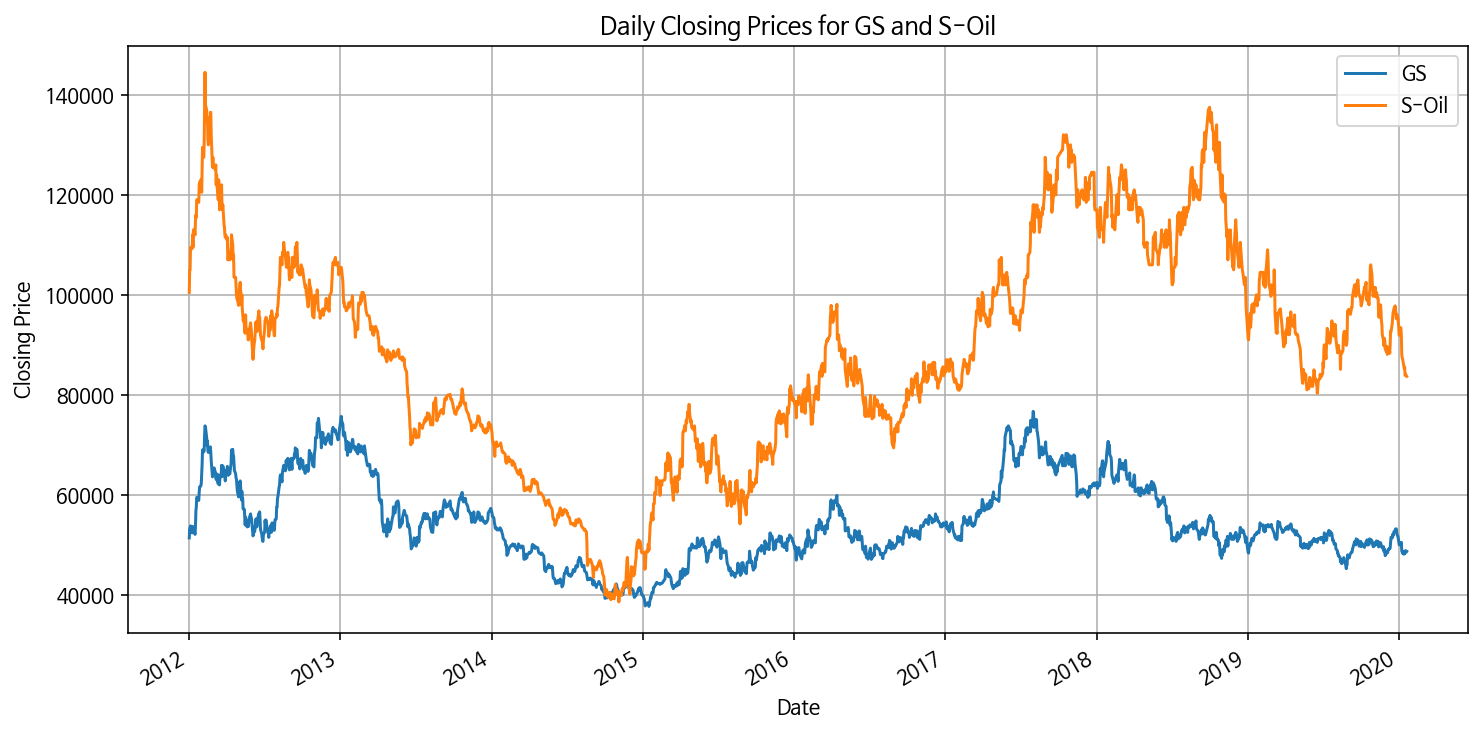

In [ ]:
# 두 자산의 움직임을 시각화
ax = pair1[[asset1, asset2]].plot(figsize=(12, 6))
ax.set_title('Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

### Calculate spread and ratio

In [ ]:
# run OLS regression
model=sm.OLS(pair1['S-Oil'], pair1.GS).fit()

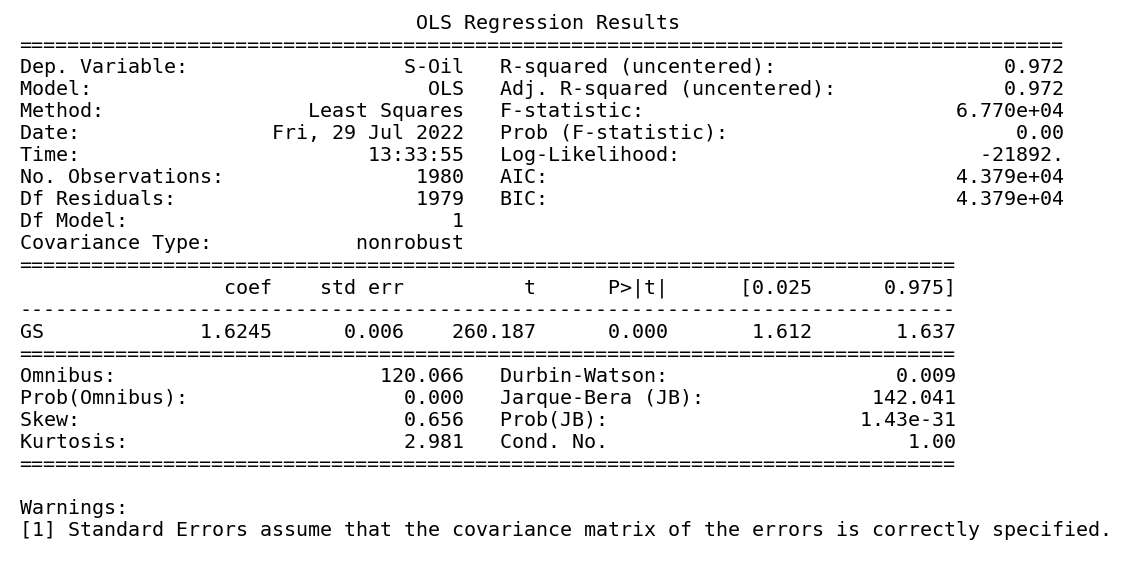

In [ ]:
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

In [ ]:
# calculate spread
spread = pair1['S-Oil'] - model.params[0] * pair1.GS

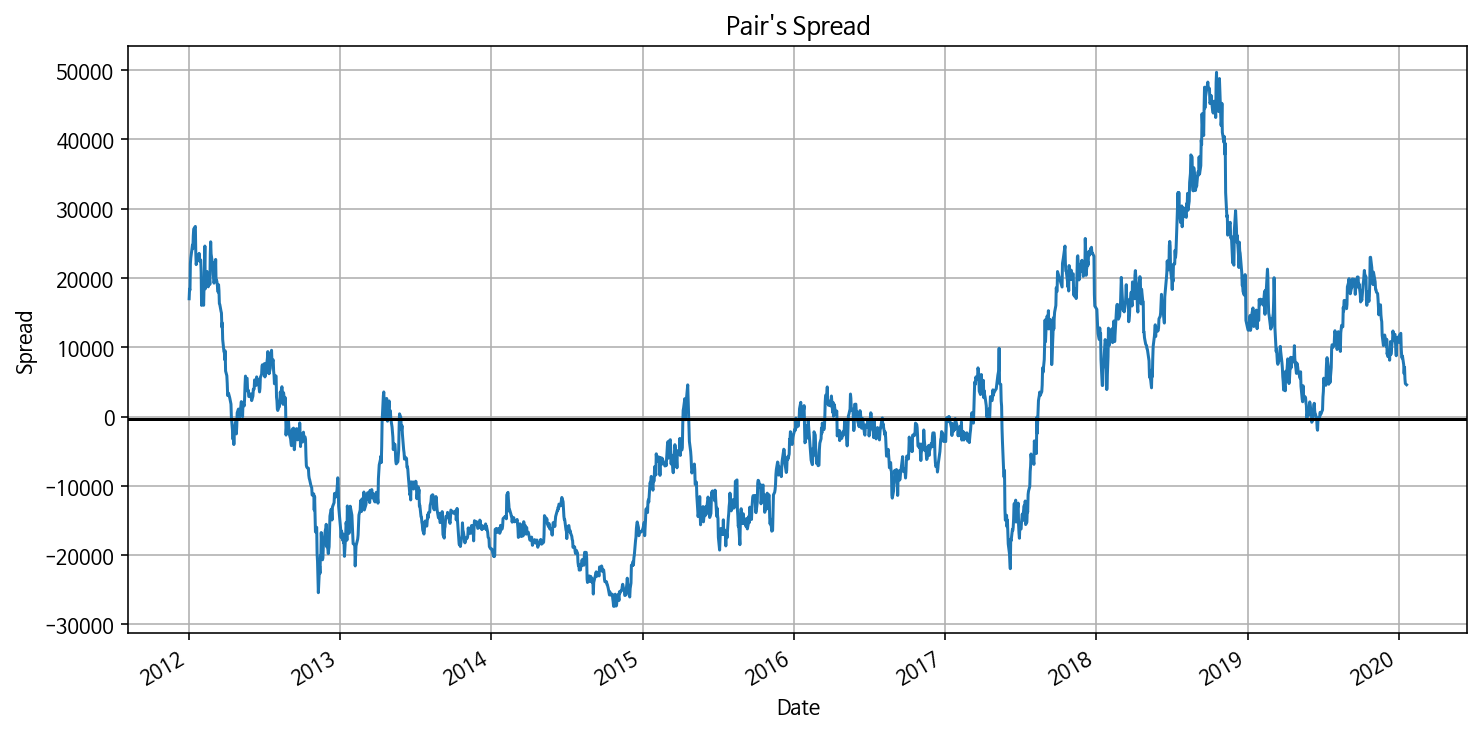

In [ ]:
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.axhline(spread.mean(), color='black')
ax.set_ylabel("Spread")
ax.grid(True)

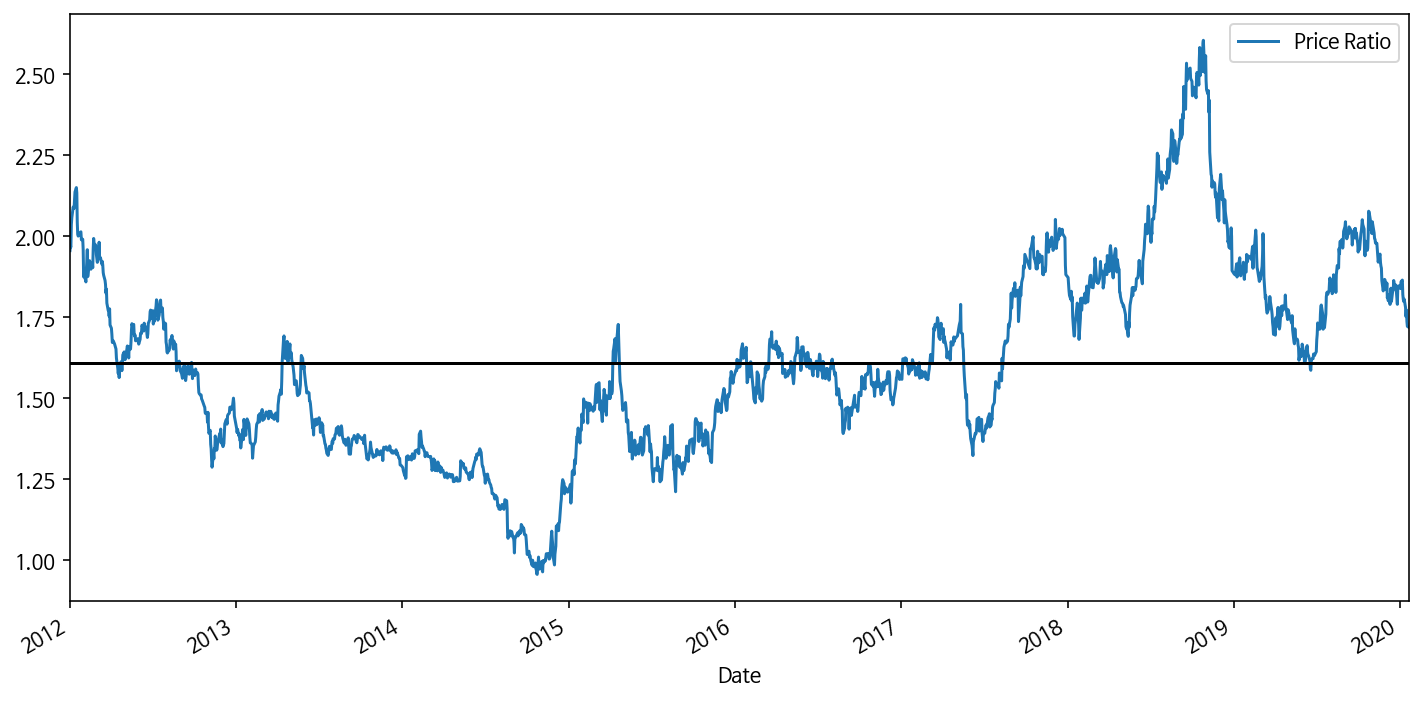

In [ ]:
# Price ratio를 그리기
ratio = pair1['S-Oil'] / pair1.GS
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2012-01-01', '2020-01-20')
plt.legend(['Price Ratio'])

## Generate Trading Signals using z-score

In [ ]:
# calculate z-score
def zscore(series):
    return (series-series.mean()) / np.std(series)

In [ ]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['GS'] = train['GS'] 
signals['S-Oil'] = train['S-Oil']
ratios = signals['GS'] / signals['S-Oil']

In [ ]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = (np.mean(signals['z']) + np.std(signals['z']))
signals['z lower limit'] = (np.mean(signals['z']) - np.std(signals['z']))

In [ ]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [ ]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [ ]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

GS     S-Oil         z  z upper limit  z lower limit  \
Date                                                                    
2012-01-02  51400.0  100500.0 -1.110667            1.0           -1.0   
2012-01-03  53300.0  105000.0 -1.142929            1.0           -1.0   
2012-01-04  53400.0  105000.0 -1.134893            1.0           -1.0   
2020-01-16  48300.0   83900.0 -0.568631            1.0           -1.0   
2020-01-17  48850.0   84100.0 -0.525004            1.0           -1.0   
2020-01-20  48700.0   83700.0 -0.516703            1.0           -1.0   

            signals1  positions1  signals2  positions2  
Date                                                    
2012-01-02         1         NaN        -1         NaN  
2012-01-03         1         0.0        -1         0.0  
2012-01-04         1         0.0        -1         0.0  
2020-01-16         0         0.0         0         0.0  
2020-01-17         0         0.0         0         0.0  
2020-01-20         0         0.0         0         0.0

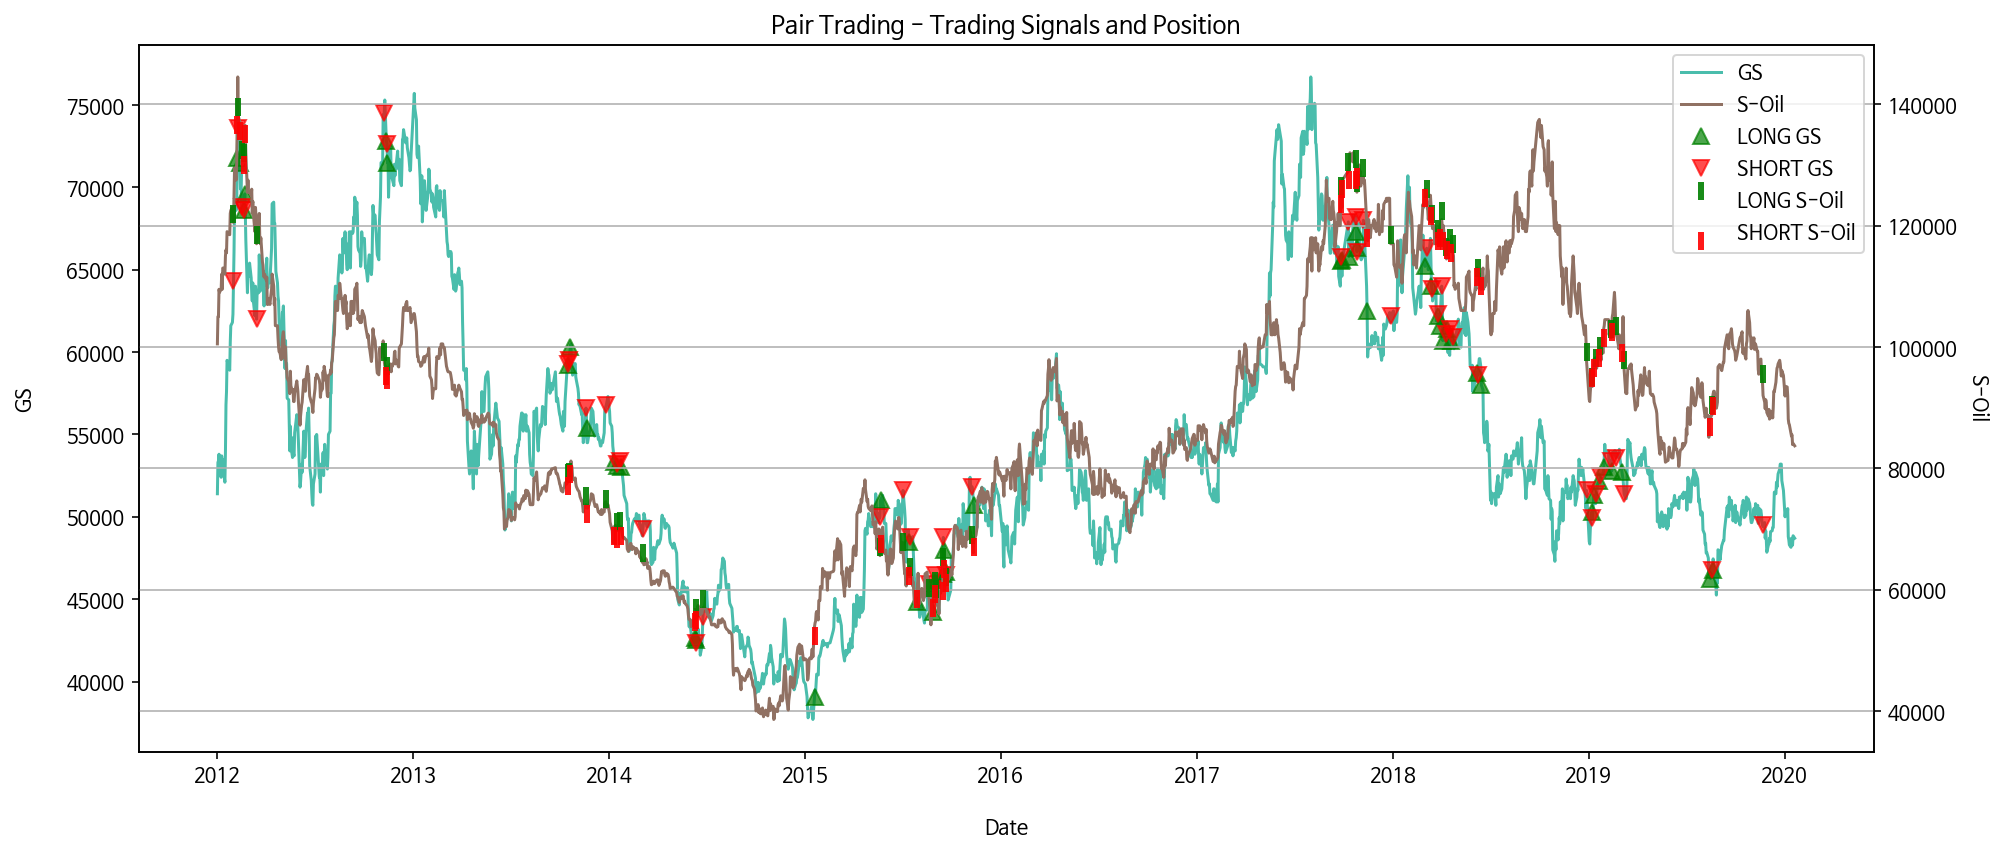

In [ ]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['GS'], c='#4abdac')
l2, = bx2.plot(signals['S-Oil'], c='#907163')

u1, = bx.plot(signals['GS'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['GS'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['S-Oil'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['S-Oil'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format("GS"),
           'SHORT {}'.format("GS"),
           'LONG {}'.format("S-Oil"),
           'SHORT {}'.format("S-Oil")], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

## Portfolio Profit and Loss Calculation

In [ ]:
# initial capital to calculate the actual pnl
initial_capital = 1e8 / 2

# shares to buy for each position
positions1 = initial_capital// max(signals['GS'])
positions2 = initial_capital// max(signals['S-Oil'])

In [ ]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['GS'] = signals['GS']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['GS'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['GS'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [ ]:
portfolio['S-Oil'] = signals['S-Oil']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['S-Oil'] * positions1
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['S-Oil'] * positions1).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [ ]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

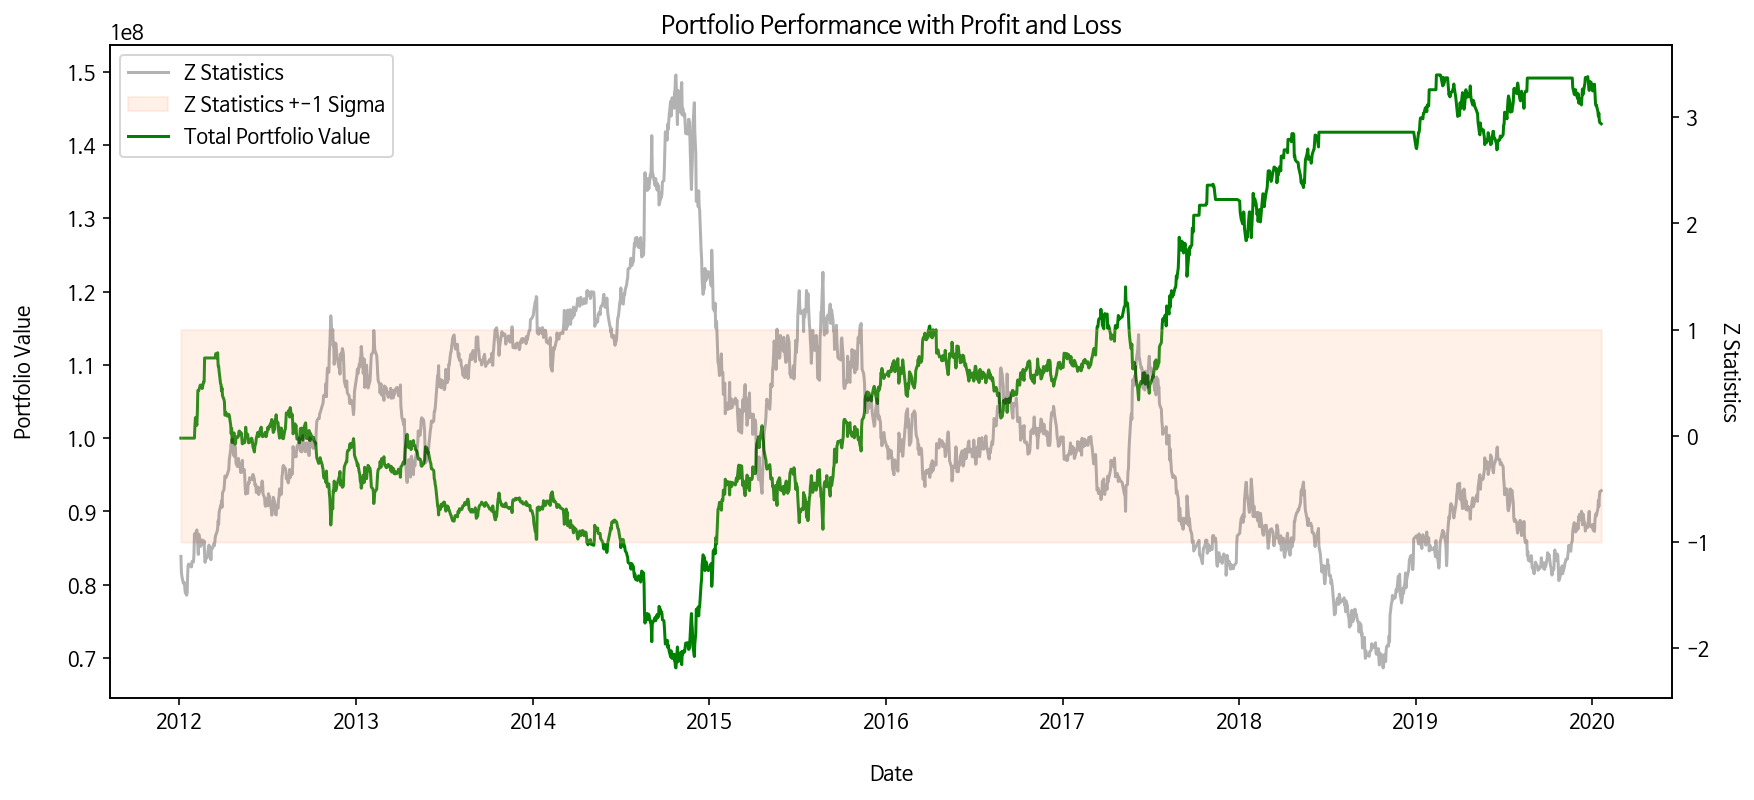

In [ ]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left')

In [ ]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)

Number of days =  2938


In [ ]:
YEAR_DAYS = 252
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 3.107%


### Portfolio(All pairs)

In [ ]:
def trade(S1, S2, bound, initial_capital, train_set=True):
    if train_set:
        signals = pd.DataFrame()
        signals[S1] = train[S1] 
        signals[S2] = train[S2]
    else:
        signals = pd.DataFrame()
        signals[S1] = test[S1]
        signals[S2] = test[S2]
        
    ratios = signals[S1] / signals[S2]
    signals['z'] = zscore(ratios)
    signals['z upper limit'] = (np.mean(signals['z']) + np.std(signals['z'])) * abs(bound)
    signals['z lower limit'] = (np.mean(signals['z']) - np.std(signals['z'])) * abs(bound)
    
    signals['signals1'] = 0
    signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
    
    signals['positions1'] = signals['signals1'].diff()
    signals['signals2'] = -signals['signals1']
    signals['positions2'] = signals['signals2'].diff()
    
    # initial capital to calculate the actual pnl
    initial_capital = initial_capital/2

    # shares to buy for each position
    positions1 = initial_capital// max(signals[S1])
    positions2 = initial_capital// max(signals[S2])
    
    # since there are two assets, we calculate each asset Pnl separately 
    # and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = signals[S1]
    portfolio['holdings1'] = signals['positions1'].cumsum() * signals[S1] * positions1
    portfolio['cash1'] = initial_capital - (signals['positions1'] * signals[S1] * positions1).cumsum()
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = signals['positions1']
    
    portfolio[S2] = signals[S2]
    portfolio['holdings2'] = signals['positions2'].cumsum() * signals[S2] * positions1
    portfolio['cash2'] = initial_capital - (signals['positions2'] * signals[S2] * positions1).cumsum()
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = signals['positions2']
    
    # total pnl and z-score
    portfolio['z'] = signals['z']
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = signals['z upper limit']
    portfolio['z lower limit'] = signals['z lower limit']
    portfolio = portfolio.dropna()
    
    total_asset = portfolio['total asset']
    
    return total_asset

In [ ]:
def pair_portfolio_return(pair_list, bound, initial_capital, train_set=True):
    capital = initial_capital/len(pair_list)
    if train_set:
        total_return = []
        for pair in pair_list:
            S1, S2 = pair[0], pair[1]
            pair_return = trade(S1, S2, bound, capital, train_set=True)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = train.index[2:]
    else:
        total_return = []
        for pair in pair_list:
            S1, S2 = pair[0],pair[1]
            pair_return = trade(S1, S2, bound, capital, train_set=False)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = test.index[2:]
    return total_return

In [ ]:
total_df = pair_portfolio_return(pairs, 1, 1e10)

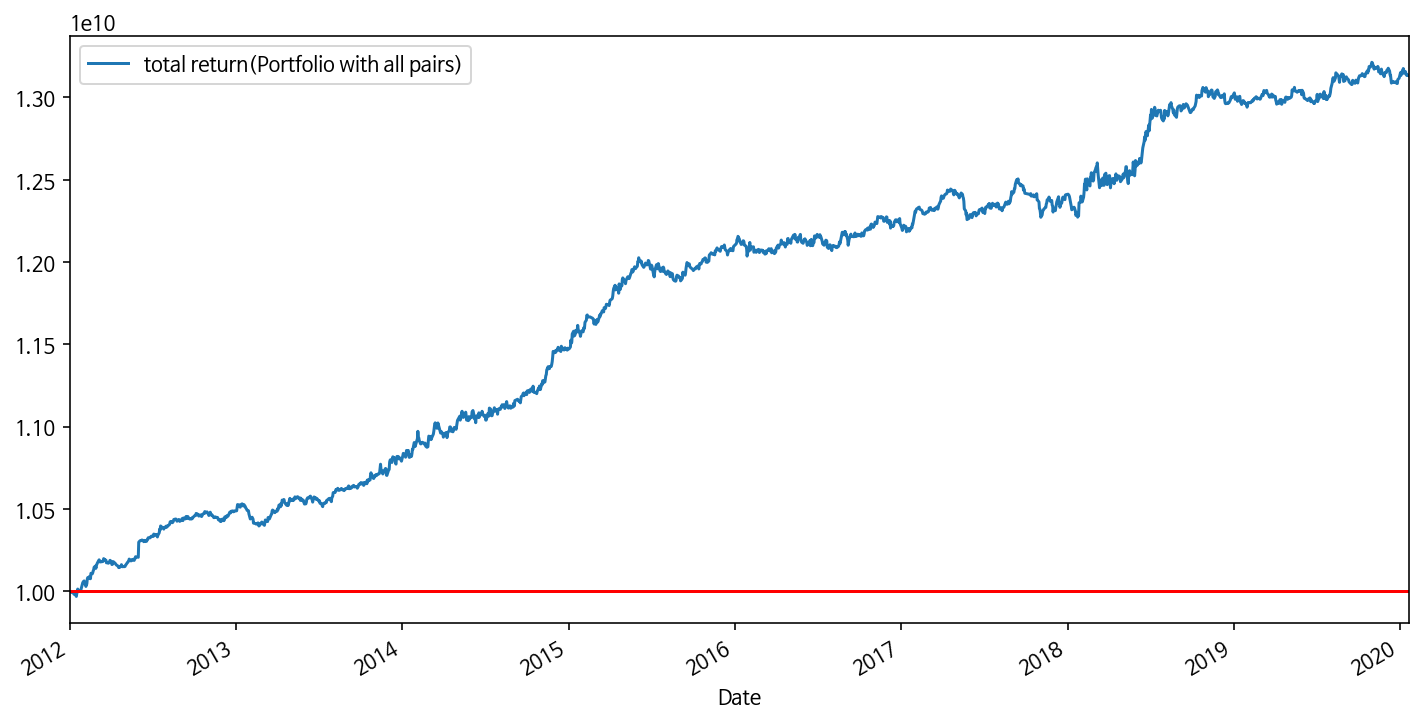

In [ ]:
total_df.plot(figsize=(12,6))
plt.axhline(1e10, color='red')
plt.xlim('2012-01-01', '2020-01-20')
plt.legend(['total return(Portfolio with all pairs)'])

## Backtest

### Backtest1(2020~2022)

(737444.0, 738336.0)

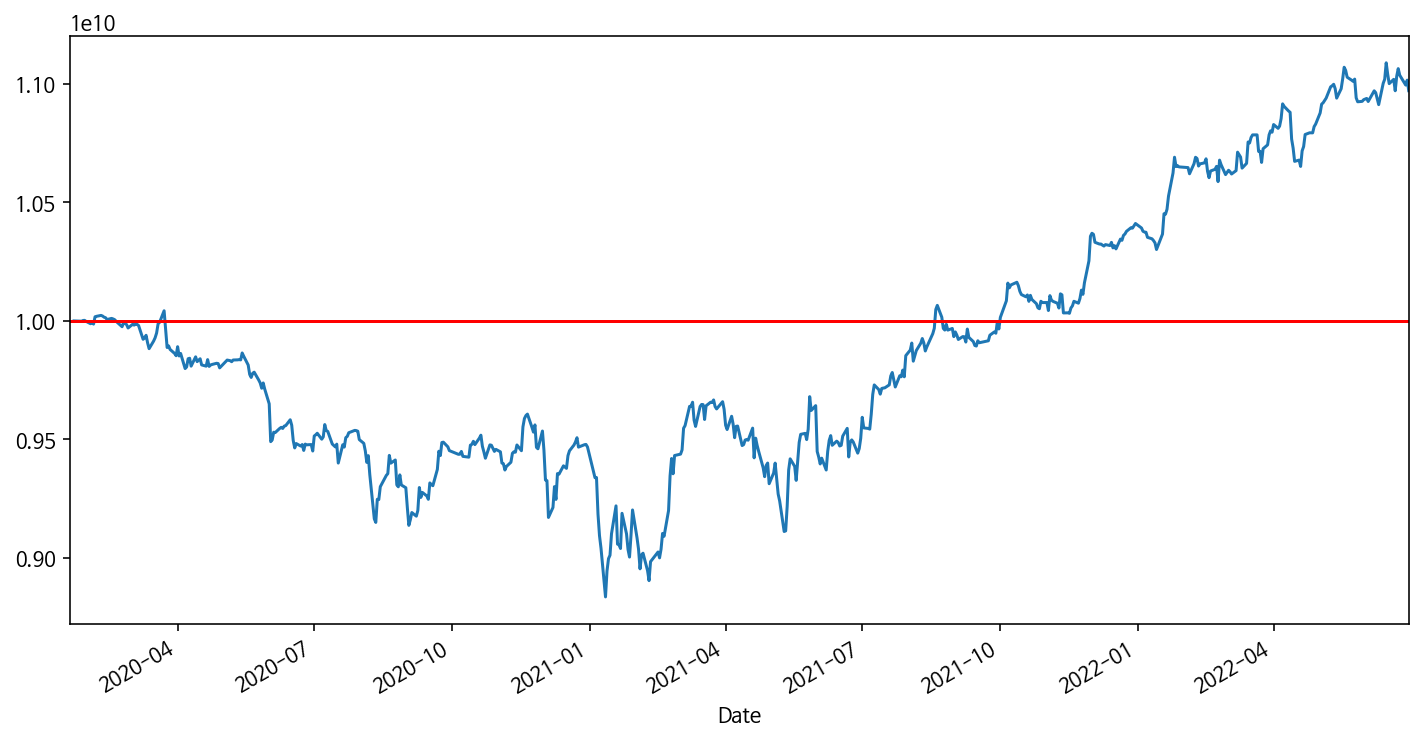

In [ ]:
total_df = pair_portfolio_return(pairs, 1, 1e10, train_set=False)

total_df.plot(figsize=(12,6))
plt.axhline(1e10, color='red')
plt.xlim('2020-01-20', '2022-06-30')

## 수익률 시각화

In [ ]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [ ]:
# use KRX300 as benchmark
benchmark = pd.read_csv('KRX300price.csv', encoding='cp949')
benchmark = benchmark[(benchmark.일자 >= "2012/01/01") & (benchmark.일자 <= '2022/06/30')].reset_index(drop=True)
benchmark = benchmark.종가.pct_change().fillna(0)
benchmark.index = df.index
benchmark.name = 'KRX300'
benchmark.head()

Date
2012-01-02    0.000000
2012-01-03    0.018593
2012-01-04    0.021235
2012-01-05   -0.008076
2012-01-06   -0.013394
Name: KRX300, dtype: float64

### Train

In [ ]:
total_df_train = pair_portfolio_return(pairs, 1, 1e10)
returns_train = total_df_train.pct_change()
returns_train.fillna(0, inplace=True)
returns_train.head()

Date
2012-01-04    0.000000
2012-01-05   -0.000298
2012-01-06    0.000060
2012-01-09   -0.000291
2012-01-10   -0.000139
dtype: float64

In [ ]:
returns_train.index = pd.to_datetime(returns_train.index)

In [ ]:
start_date = '2012-01-04'
benchmark_train = benchmark[benchmark.index >= start_date]
benchmark_train[start_date] = 0
benchmark_train.head()

Date
2012-01-04    0.000000
2012-01-05   -0.008076
2012-01-06   -0.013394
2012-01-09   -0.022028
2012-01-10    0.008338
Name: KRX300, dtype: float64

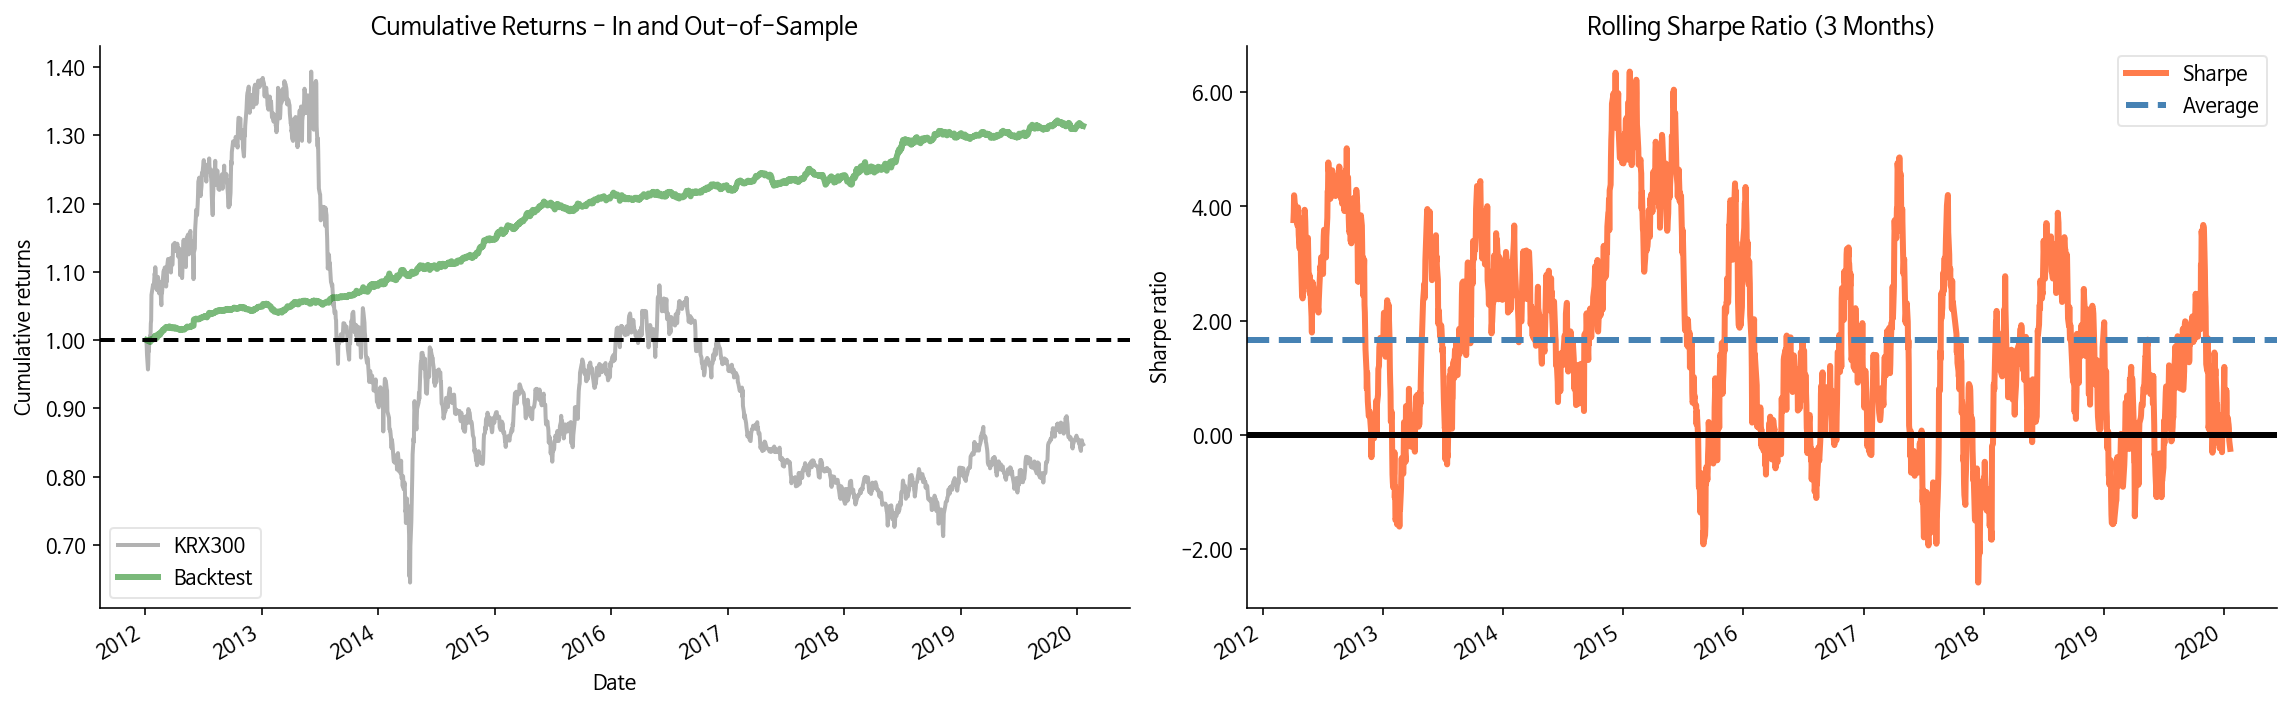

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns_train,
                     factor_returns=benchmark_train,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(returns_train, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

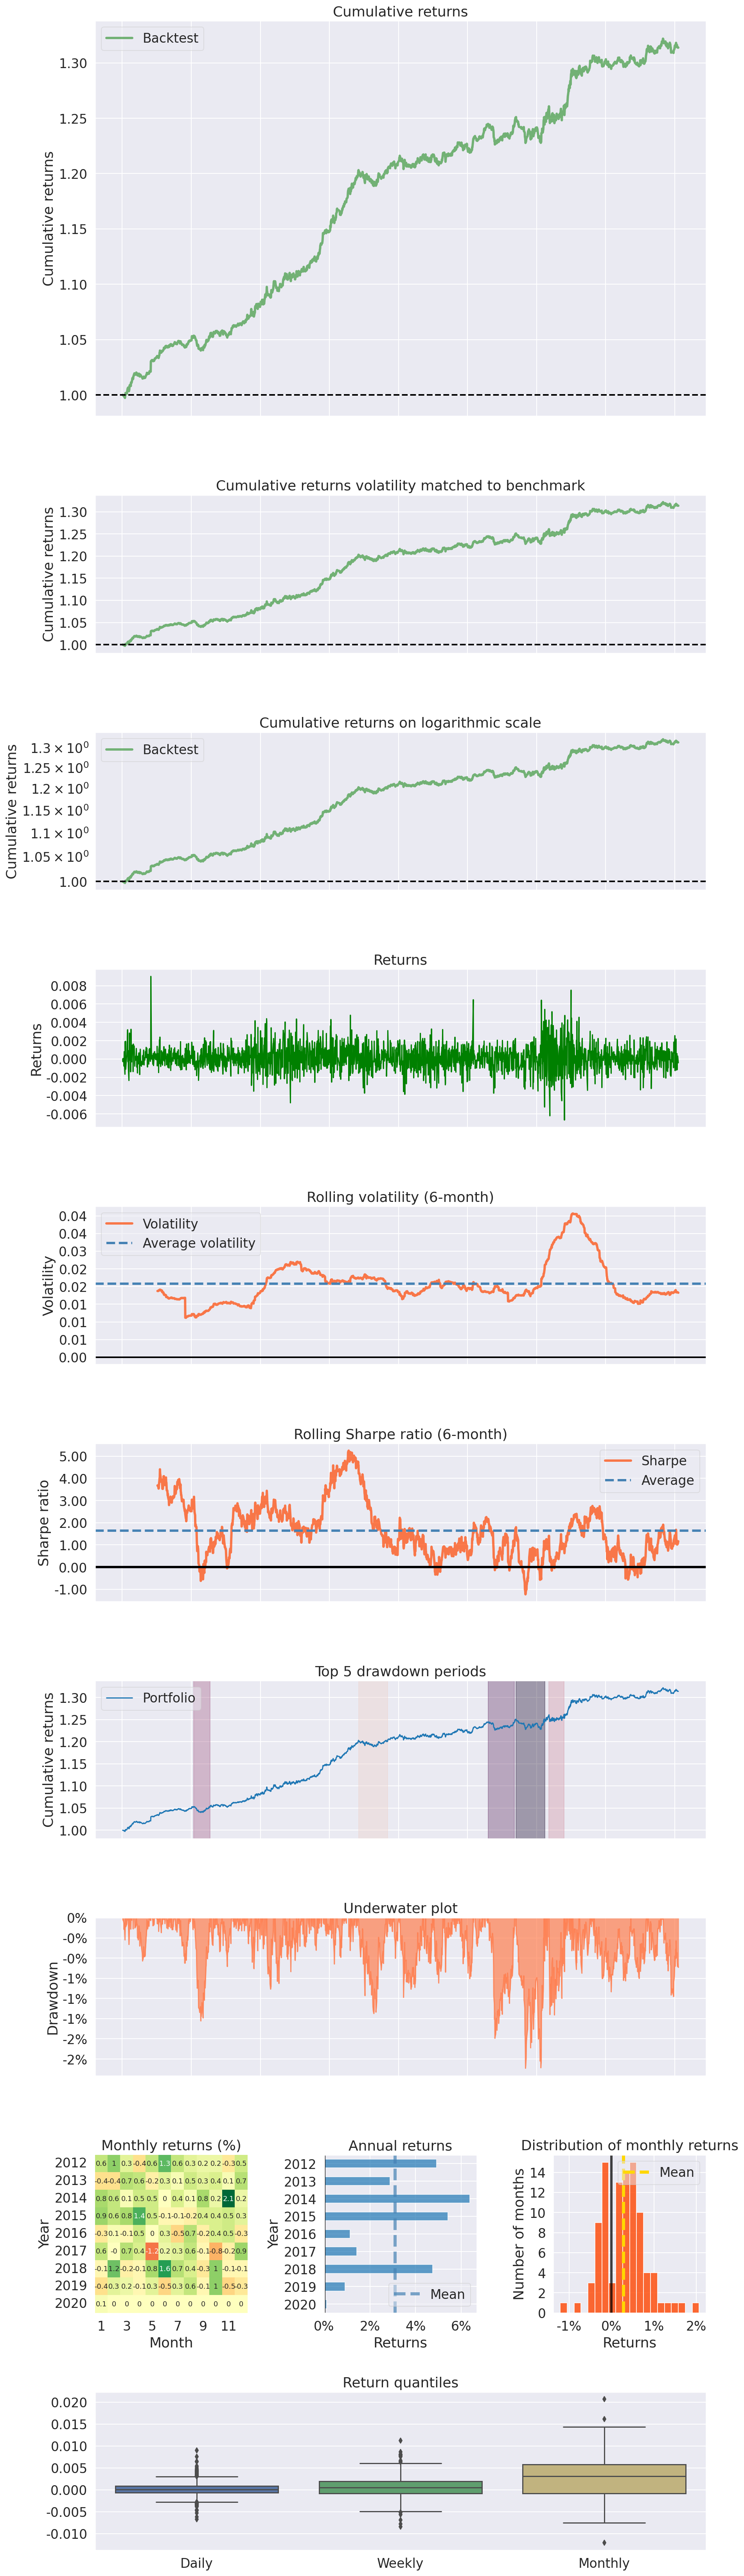

In [ ]:
pf.create_returns_tear_sheet(returns_train)

### Test

In [ ]:
total_df_test = pair_portfolio_return(pairs, 1, 1e10, train_set=False)
returns_test = total_df_test.pct_change()
returns_test.fillna(0, inplace=True)
returns_test.head()

Date
2020-01-23    0.000000
2020-01-28   -0.000113
2020-01-29    0.000293
2020-01-30    0.000077
2020-01-31   -0.000434
dtype: float64

In [ ]:
start_date = '2020-01-23'
benchmark_test = benchmark[benchmark.index >= start_date]
benchmark_test[start_date] = 0
benchmark_test.head()

Date
2020-01-23    0.000000
2020-01-28   -0.010653
2020-01-29   -0.000337
2020-01-30    0.006160
2020-01-31   -0.003080
Name: KRX300, dtype: float64

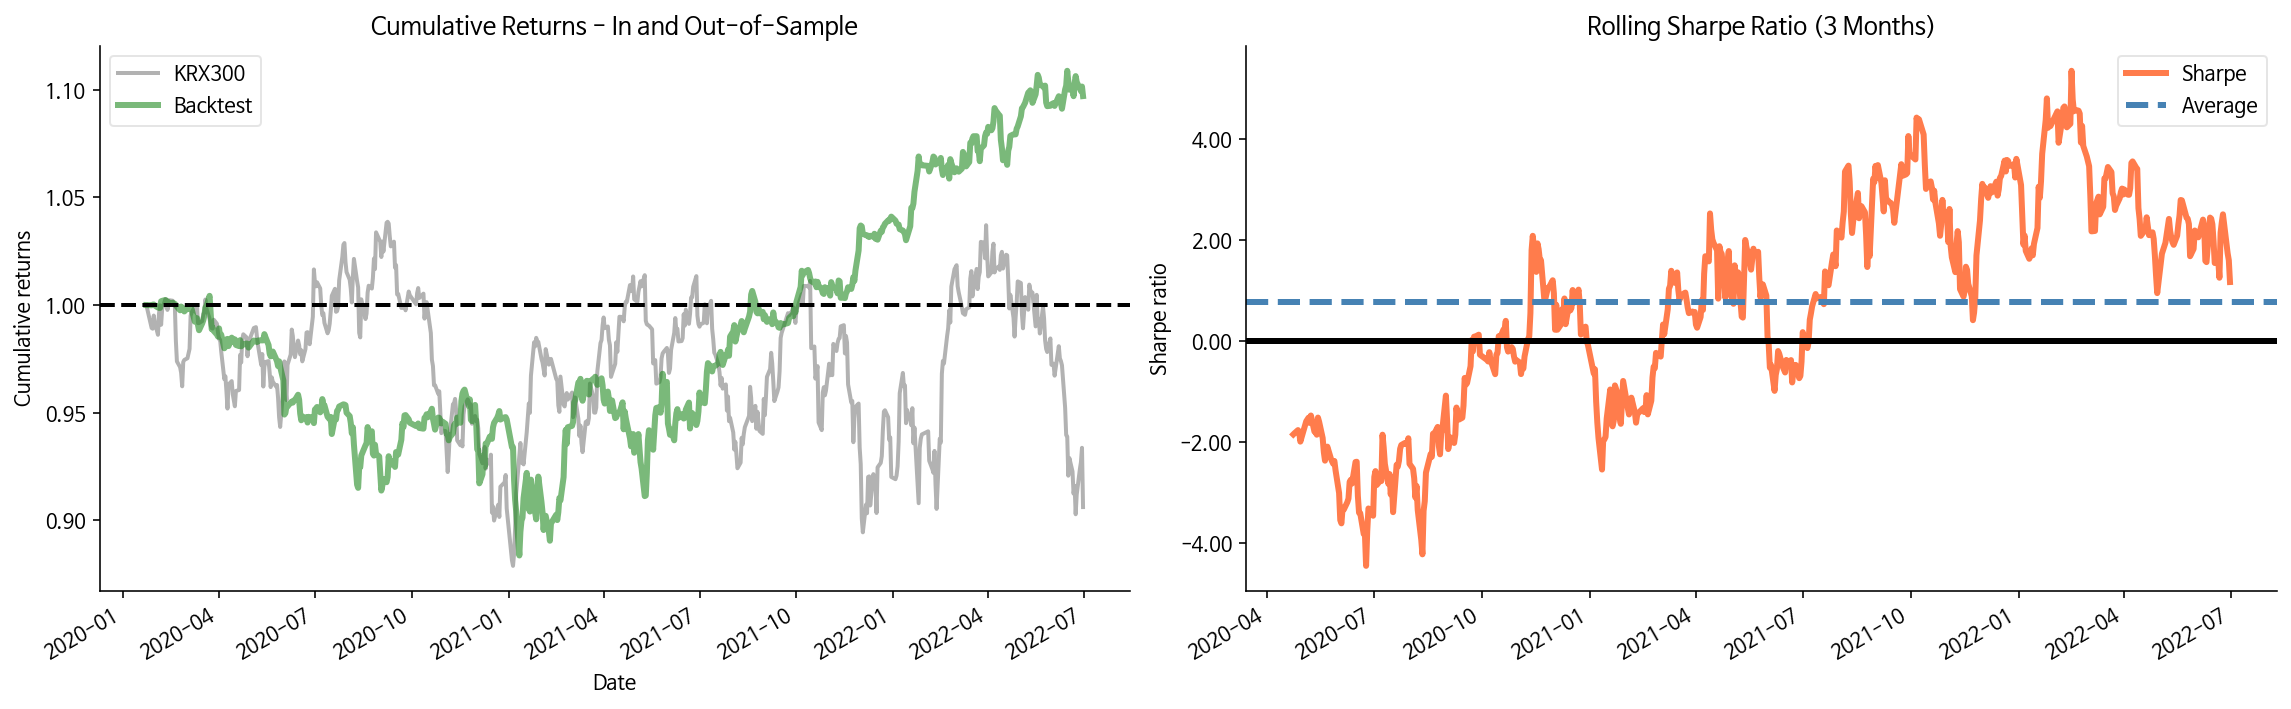

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns_test,
                     factor_returns=benchmark_test,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(returns_test, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

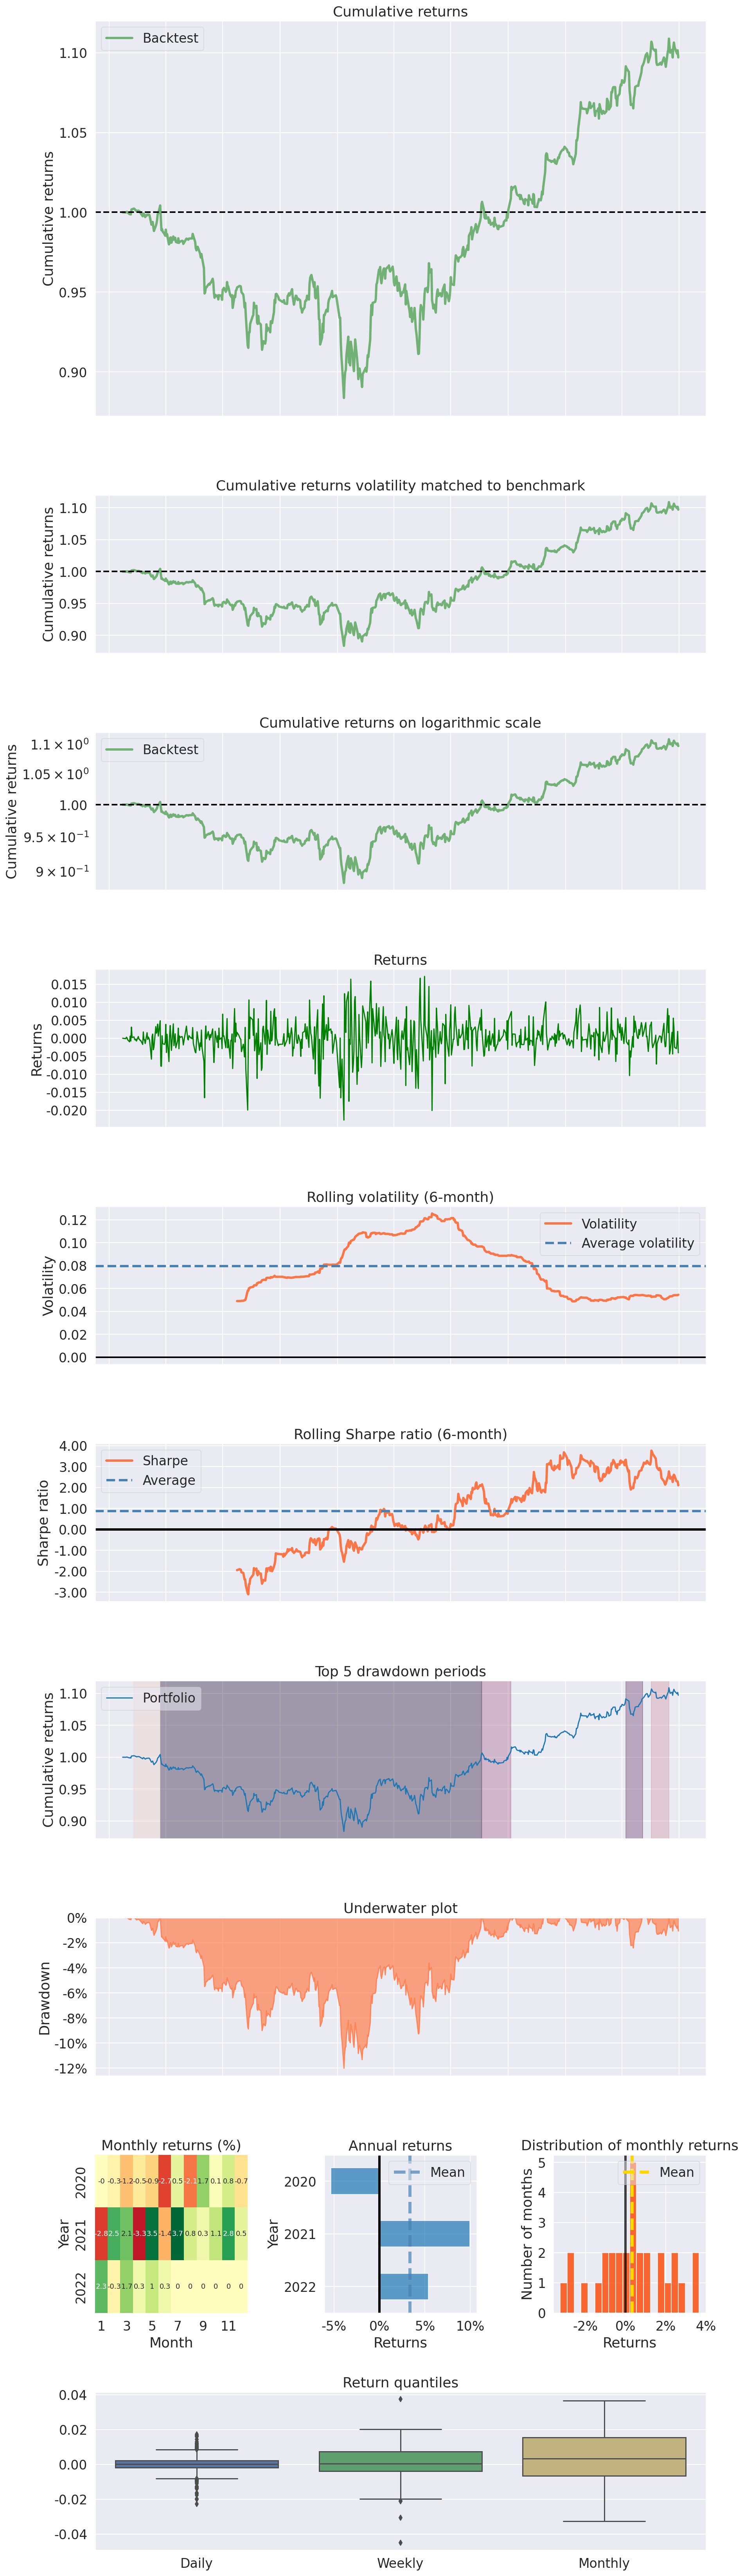

In [ ]:
pf.create_returns_tear_sheet(returns_test)

### ALL

In [ ]:
test = df

In [ ]:
total_df_all = pair_portfolio_return(pairs, 1, 1e10, train_set=False)
returns_all = total_df_all.pct_change()
returns_all.fillna(0, inplace=True)
returns_all.head()

Date
2012-01-04    0.000000
2012-01-05    0.000000
2012-01-06    0.000715
2012-01-09   -0.000093
2012-01-10   -0.000101
dtype: float64

In [ ]:
start_date = '2012-01-04'
benchmark_all = benchmark[benchmark.index >= start_date]
benchmark_all[start_date] = 0
benchmark_all.head()

Date
2012-01-04    0.000000
2012-01-05   -0.008076
2012-01-06   -0.013394
2012-01-09   -0.022028
2012-01-10    0.008338
Name: KRX300, dtype: float64

In [ ]:
LIVE_DATE='2020-01-20'

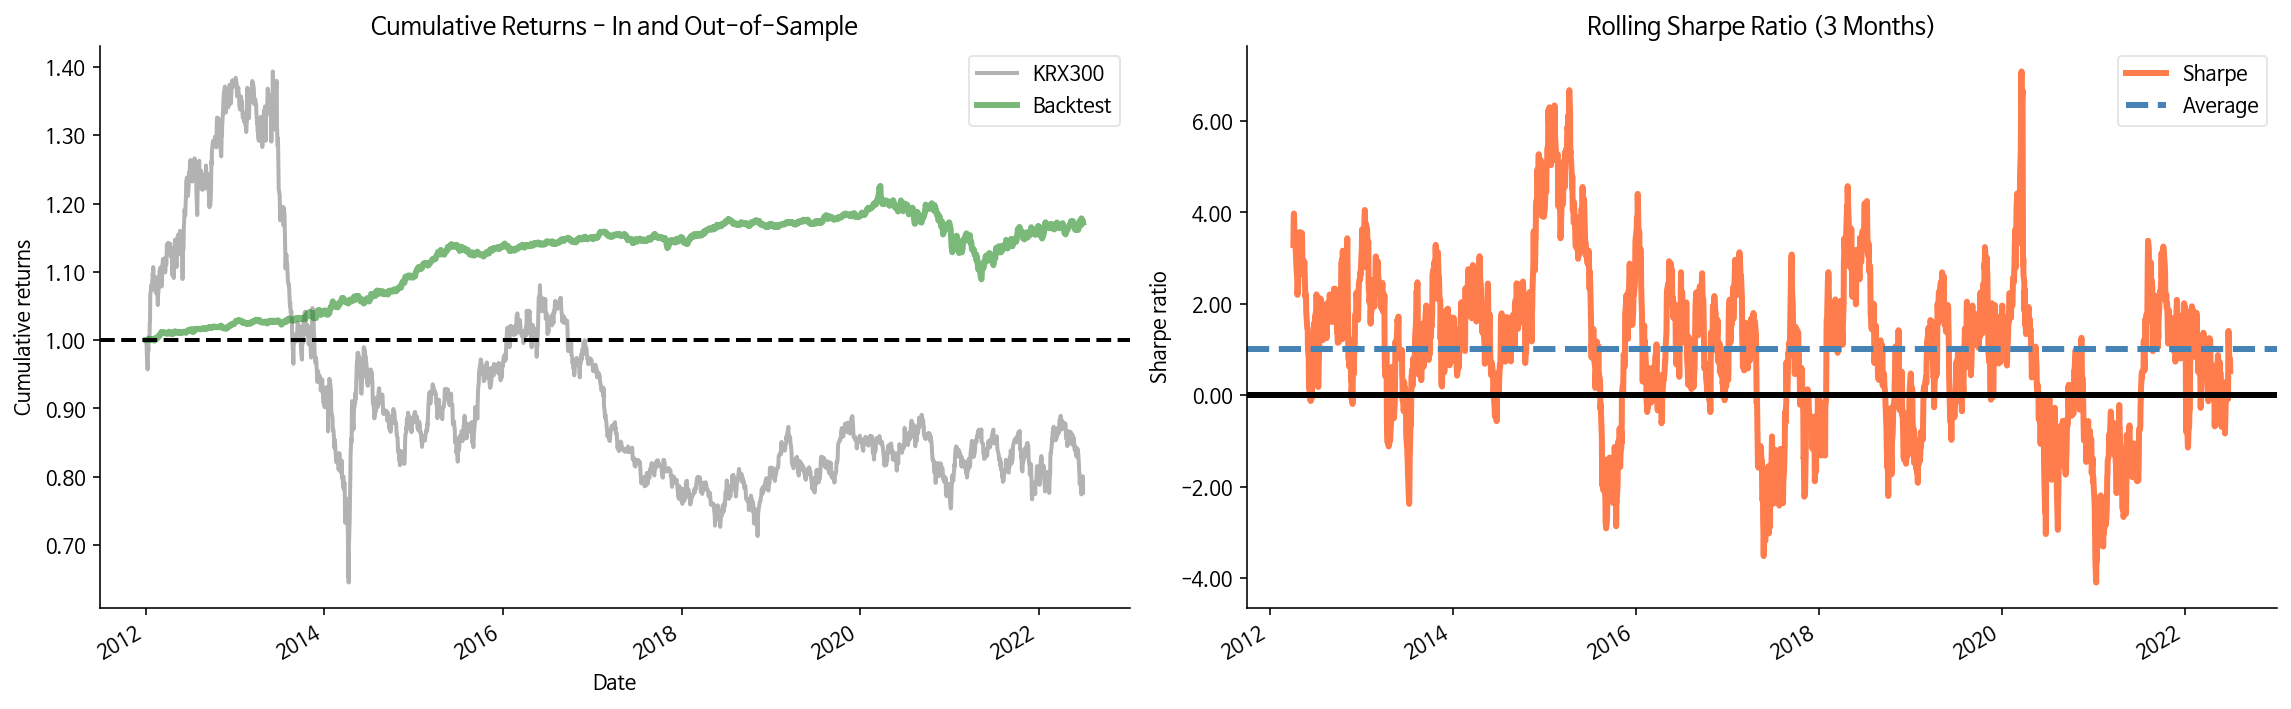

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns_all,
                     factor_returns=benchmark_all,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns_all, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

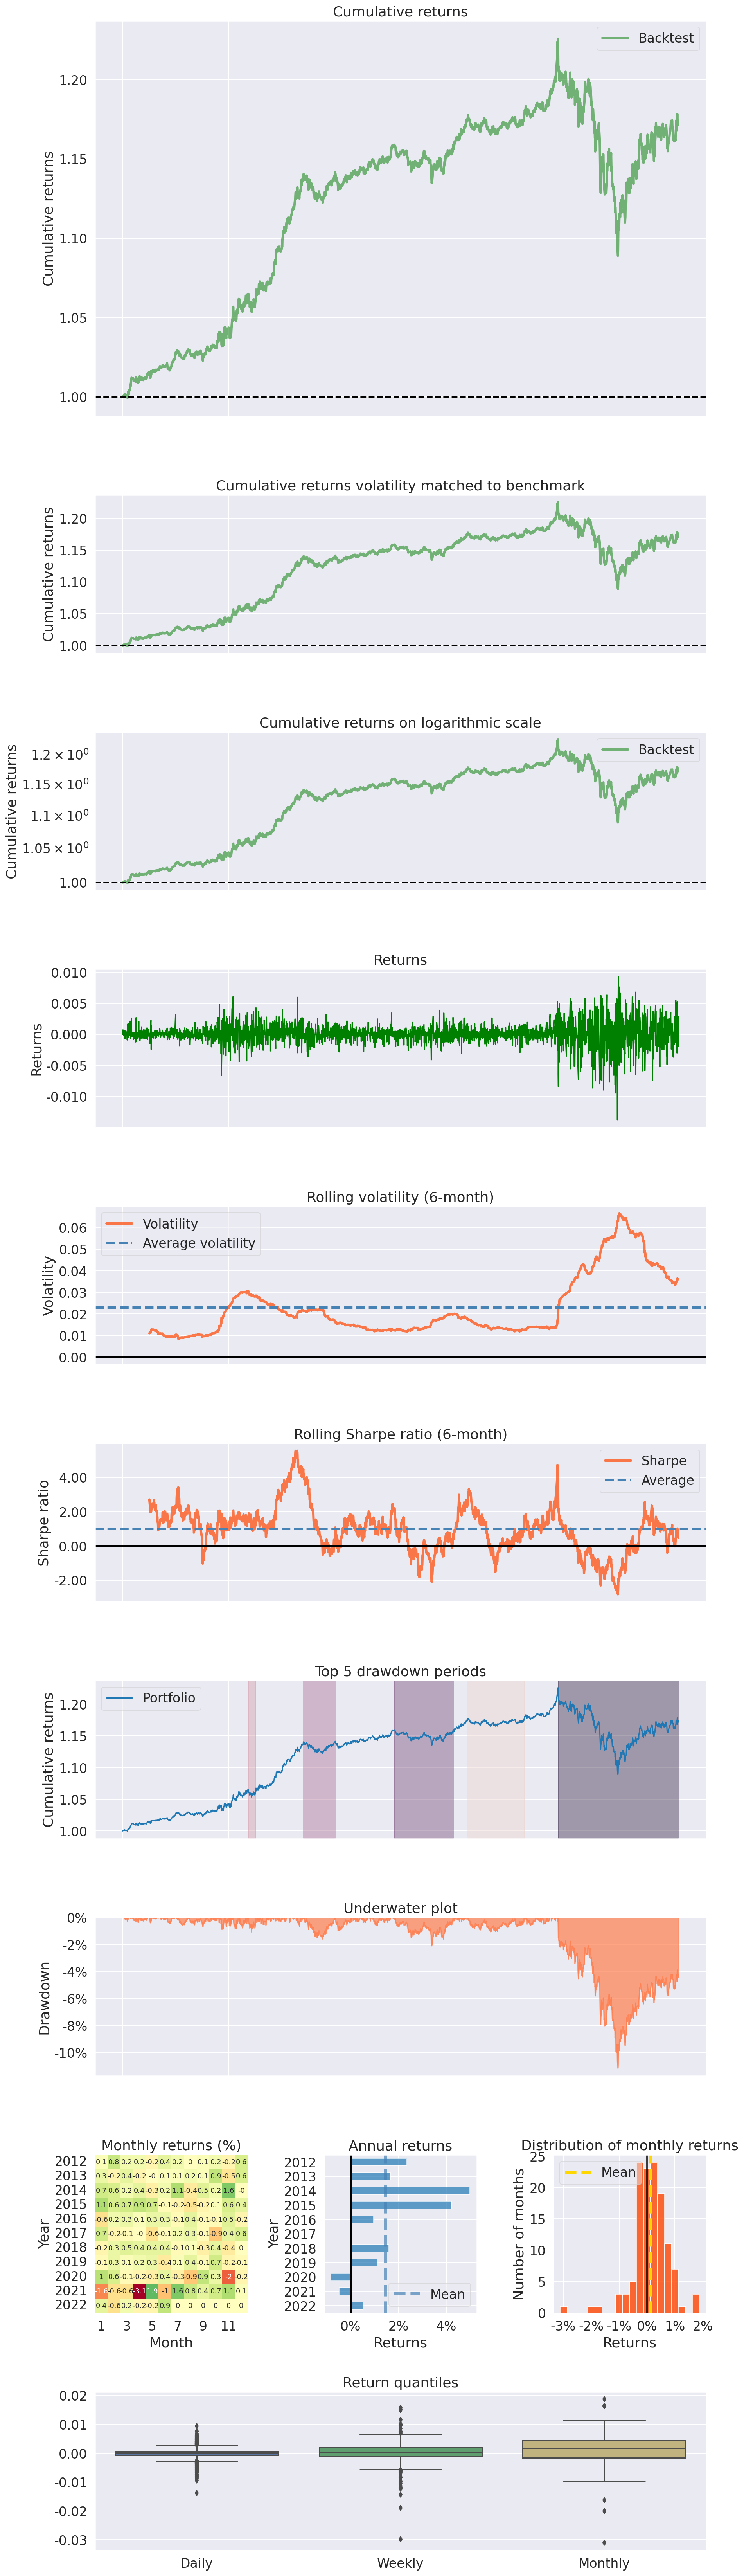

In [ ]:
pf.create_returns_tear_sheet(returns_all)